In [135]:
import torch
from model import CNN
import numpy as np
from fmnist_dataset import load_fashion_mnist
from torch.utils.data import DataLoader
import torch.nn as nn
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model.load_state_dict(torch.load('../model/ep_37_devacc_92.99_.pt'))

train, dev, test = load_fashion_mnist("../data", random=random)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [136]:
select_correct_classfied_images = []
select_correct_classfied_labels = []

model.eval()

for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        initial_outputs = model(images)
        initial_preds = initial_outputs.argmax(dim=1, keepdim=True).squeeze(1)
    
    correct_indices = initial_preds == labels
    for i in range(len(images)):
        if correct_indices[i]:
            select_correct_classfied_images.append(images[i].cpu().numpy())
            select_correct_classfied_labels.append(labels[i].item())
            if len(select_correct_classfied_images) == 1000:
                break

    if len(select_correct_classfied_images) == 1000:
        break

In [137]:
select_correct_classfied_images[0].shape

(1, 28, 28)

In [138]:
select_correct_classified_images_tensor = torch.tensor(select_correct_classfied_images, dtype=torch.float32)
select_correct_classified_labels_tensor = torch.tensor(select_correct_classfied_labels, dtype=torch.long)

import nbimporter

from white_box_attack import WhiteboxAttackDataset

select_correct_classified_dataset = WhiteboxAttackDataset(select_correct_classified_images_tensor, select_correct_classified_labels_tensor)
select_correct_classified_loader = DataLoader(select_correct_classified_dataset, batch_size=64, shuffle=True)


len(select_correct_classified_dataset)

1000

In [139]:
from white_box_attack import whitebox_attack
from black_box_attack import mcmc_blackbox_attack

target_mapping = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

# 进行 white-box attack
adversarial_samples = whitebox_attack(model, select_correct_classified_loader, target_mapping, device)

# 输出结果
print(f"Generated {len(adversarial_samples)} adversarial examples.")
print(f"Success white-box attack rate: {len(adversarial_samples) / len(select_correct_classified_dataset) * 100:.2f}%")
for ori_img, per_img, orig_label, adv_label in adversarial_samples[:10]:
    print(f"Original label: {orig_label}, Adversarial label: {adv_label}")

Generated 55 adversarial examples.
Generated 114 adversarial examples.
Generated 174 adversarial examples.
Generated 231 adversarial examples.
Generated 288 adversarial examples.
Generated 346 adversarial examples.
Generated 405 adversarial examples.
Generated 465 adversarial examples.
Generated 524 adversarial examples.
Generated 583 adversarial examples.
Generated 639 adversarial examples.
Generated 701 adversarial examples.
Generated 758 adversarial examples.
Generated 818 adversarial examples.
Generated 875 adversarial examples.
Generated 912 adversarial examples.
Generated 912 adversarial examples.
Success white-box attack rate: 91.20%
Original label: 3, Adversarial label: 4
Original label: 2, Adversarial label: 3
Original label: 8, Adversarial label: 9
Original label: 3, Adversarial label: 4
Original label: 2, Adversarial label: 3
Original label: 5, Adversarial label: 6
Original label: 3, Adversarial label: 4
Original label: 3, Adversarial label: 4
Original label: 6, Adversarial 

In [140]:
print(len(adversarial_samples))
print(adversarial_samples[0][0].shape)
print(adversarial_samples[0][1].shape)
print(adversarial_samples[0][2])
print(adversarial_samples[0][3])

912
(1, 28, 28)
(1, 28, 28)
3
4


In [141]:
# 将对抗样本掺入训练集
for ori_img, per_img, orig_label, adv_label in adversarial_samples:
    train.x.append(torch.tensor(per_img).squeeze(0)) # per_img shape: (1, 28, 28)
    train.y.append(torch.tensor(orig_label))

# train[0][0].shape
# train[0][1]
print(len(train))

train_loader = DataLoader(train, batch_size=64, shuffle=True)

50912


In [143]:
from train import trainEpochs
from torch import optim

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
else:
    device = torch.device('cpu')
    torch.manual_seed(42)

criterion = nn.CrossEntropyLoss()

classifier = CNN().to(device)

optimizer = optim.Adam(classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

trainEpochs(classifier, optimizer, scheduler, criterion, epochs=40,\
            training_set=train_loader, dev_set=dev_loader, print_each=100, save_dir='../model/adversarial', device=device)



Ep 1
    0.8809
    0.5317
    0.4391
    0.3739
    0.3836
    0.3471
    0.3416
  dev acc = 89.19%
Ep 2
    0.3119
    0.2871
    0.3056
    0.3047
    0.2737
    0.2692
    0.2637
  dev acc = 89.38%
Ep 3
    0.2315
    0.2464
    0.2465
    0.2326
    0.2487
    0.2260
    0.2269
  dev acc = 91.00%
Ep 4
    0.1883
    0.2244
    0.2147
    0.2108
    0.2250
    0.2033
    0.2166
  dev acc = 91.42%
Ep 5
    0.1896
    0.1857
    0.1930
    0.1788
    0.2003
    0.1825
    0.1789
  dev acc = 92.36%
Ep 6
    0.1542
    0.1682
    0.1632
    0.1583
    0.1682
    0.1750
    0.1648
  dev acc = 92.21%
Ep 7
    0.1242
    0.1422
    0.1484
    0.1577
    0.1401
    0.1466
    0.1578
  dev acc = 92.20%
Ep 8
    0.1213
    0.1256
    0.1133
    0.1301
    0.1439
    0.1340
    0.1442
  dev acc = 92.48%
Ep 9
    0.1032
    0.0991
    0.1228
    0.1245
    0.1063
    0.1139
    0.1257
  dev acc = 92.53%
Ep 10
    0.0934
    0.0982
    0.1005
    0.0964
    0.1161
    0.1132
    0.0943
  dev ac

In [160]:
adversarial_model = CNN().to(device)

adversarial_model.load_state_dict(torch.load('../model/adversarial/ep_29_devacc_93.33_.pt'))

from test import evaluate   
acc = evaluate(adversarial_model, test_loader, device)
print (' test acc = %.2f%%' % acc)

 test acc = 92.99%


In [171]:
# 白盒攻击
select_correct_classfied_images = []
select_correct_classfied_labels = []

adversarial_model.eval()

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        initial_outputs = adversarial_model(images)
        initial_preds = initial_outputs.argmax(dim=1, keepdim=True).squeeze(1)
    
    correct_indices = initial_preds == labels
    for i in range(len(images)):
        if correct_indices[i]:
            select_correct_classfied_images.append(images[i].cpu().numpy())
            select_correct_classfied_labels.append(labels[i].item())
            if len(select_correct_classfied_images) == 1000:
                break

    if len(select_correct_classfied_images) == 1000:
        break

select_correct_classified_images_tensor = torch.tensor(select_correct_classfied_images, dtype=torch.float32)
select_correct_classified_labels_tensor = torch.tensor(select_correct_classfied_labels, dtype=torch.long)

select_correct_classified_dataset = WhiteboxAttackDataset(select_correct_classified_images_tensor, select_correct_classified_labels_tensor)
select_correct_classified_loader = DataLoader(select_correct_classified_dataset, batch_size=64, shuffle=True)


# 进行 white-box attack
adversarial_samples = whitebox_attack(adversarial_model, select_correct_classified_loader, target_mapping, device)

# 输出结果
print(f"Generated {len(adversarial_samples)} adversarial examples.")
print(f"Success white-box attack rate: {len(adversarial_samples) / len(select_correct_classified_dataset) * 100:.2f}%")
for ori_img, per_img, orig_label, adv_label in adversarial_samples[:10]:
    print(f"Original label: {orig_label}, Adversarial label: {adv_label}")

Generated 55 adversarial examples.
Generated 109 adversarial examples.
Generated 167 adversarial examples.
Generated 223 adversarial examples.
Generated 280 adversarial examples.
Generated 334 adversarial examples.
Generated 390 adversarial examples.
Generated 444 adversarial examples.
Generated 497 adversarial examples.
Generated 551 adversarial examples.
Generated 607 adversarial examples.
Generated 666 adversarial examples.
Generated 722 adversarial examples.
Generated 775 adversarial examples.
Generated 826 adversarial examples.
Generated 862 adversarial examples.
Generated 862 adversarial examples.
Success white-box attack rate: 86.20%
Original label: 3, Adversarial label: 4
Original label: 3, Adversarial label: 4
Original label: 9, Adversarial label: 0
Original label: 2, Adversarial label: 3
Original label: 2, Adversarial label: 3
Original label: 2, Adversarial label: 3
Original label: 2, Adversarial label: 3
Original label: 8, Adversarial label: 9
Original label: 4, Adversarial 

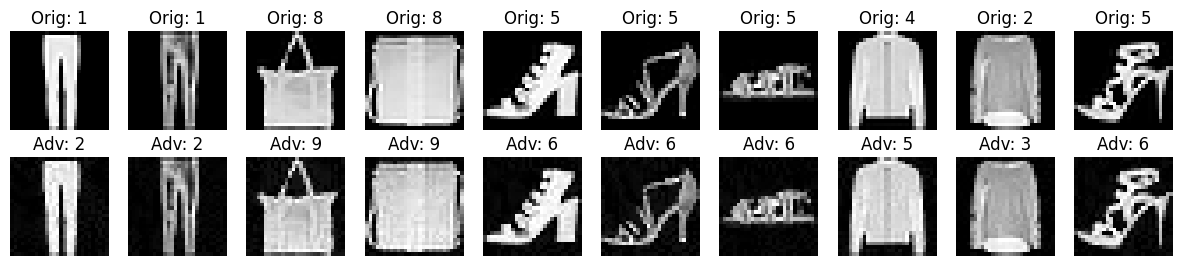

In [172]:
selected_samples = random.sample(adversarial_samples, 10)

import matplotlib.pyplot as plt

# 显示图像和分类结果
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i, (original_img, perturbed_img, orig_label, adv_label) in enumerate(selected_samples):
    # 展示原始图像
    axs[0, i].imshow(original_img.reshape(28, 28), cmap='gray') 
    axs[0, i].title.set_text(f"Orig: {orig_label}")
    axs[0, i].axis('off')

    # 展示对抗样本图像
    axs[1, i].imshow(perturbed_img.reshape(28, 28), cmap='gray') 
    axs[1, i].title.set_text(f"Adv: {adv_label}")
    axs[1, i].axis('off')

plt.show()

In [177]:
adversarial_samples = mcmc_blackbox_attack(adversarial_model, select_correct_classified_loader, target_mapping, device,\
                                           sigma = 40, delta_max= 900, max_iter=1000)


print("Number of adversarial samples:", len(adversarial_samples))
print(f"Success black-box attack rate: {len(adversarial_samples) / len(select_correct_classified_images_tensor) * 100:.2f}%")

Current adversarial samples count: 15
Current adversarial samples count: 29
Current adversarial samples count: 45
Current adversarial samples count: 59
Current adversarial samples count: 73
Current adversarial samples count: 84
Current adversarial samples count: 99
Current adversarial samples count: 111
Current adversarial samples count: 124
Current adversarial samples count: 140
Current adversarial samples count: 155
Current adversarial samples count: 166
Current adversarial samples count: 180
Current adversarial samples count: 193
Current adversarial samples count: 206
Current adversarial samples count: 214
Number of adversarial samples: 214
Success black-box attack rate: 21.40%


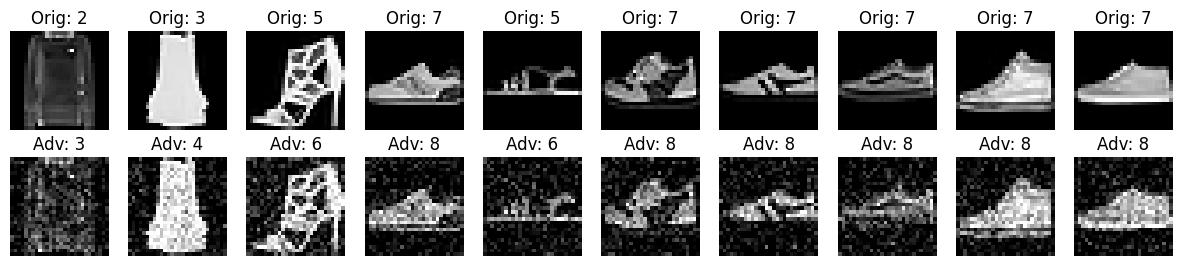

In [183]:
blackbox_selected_samples = random.sample(adversarial_samples, 10)

import matplotlib.pyplot as plt

# 显示图像和分类结果
fig, axs = plt.subplots(2, 10, figsize=(15, 3))

for i, (ori_img, adv_img, ori_label, adv_label) in enumerate(blackbox_selected_samples):
    # 展示原始图像
    axs[0, i].imshow(ori_img.cpu().reshape(28,28), cmap='gray') 
    axs[0, i].title.set_text(f"Orig: {ori_label}")
    axs[0, i].axis('off')

    # 展示对抗样本图像
    axs[1, i].imshow(adv_img.cpu().reshape(28, 28), cmap='gray') 
    axs[1, i].title.set_text(f"Adv: {adv_label}")
    axs[1, i].axis('off')

plt.show()